<a href="https://colab.research.google.com/github/sehynes/MIT-Data-Scienc-e/blob/main/SeanHynes_Malaria_DeepLearning_Milestone2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Malaria Detection: Deep Learning (A)**

# **Capstone Milestone 2**

This project uses deep learning to detect malaria from cell images of parasitized and uninfected malaria blood cells.

•	The comprehensive Problem Statement, Objective Statement, Proposed Approach, proposed Measures of Success, and description of the Data Exploration results can be found in the Milestone 1 report for this project.  
•	For Milestone 2, we executed various approaches and compared various model.  Some refinements were made to the proposed approach based on insights gleaned in the process.  
•	First, a baseline, simple CNN model is used to establish baseline measures.  Then, the baseline CNN model is expanded with various techniques.  Various data augmentation approaches were experimented with.  And finally, well known VGG and Xception models were utilized with pre-trained weights to perform transfer learning.
•	This notebook provides refined insights and comparisons of the various models and techniques.  


### <b> Mounting the Drive

In [1]:
#Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')


Mounted at /content/drive
Your runtime has 37.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [2]:
!pip install ipython-autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### <b>Loading libraries</b>

In [3]:
#Importing libraries required to load the data
#Importing libraries required to load the data
import time
from datetime import date
from datetime import datetime
%load_ext autotime
notebook_starttime = datetime.now()

import zipfile
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, LeakyReLU, GlobalAvgPool2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers

from tensorflow.keras import backend
from tensorflow.keras.layers import MaxPooling2D 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Model

from keras.models import model_from_json

import cv2
import random
from random import shuffle

#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Remove the limit from the number of displayed columns and rows. It helps to see the entire dataframe while printing it
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

print(tf.__version__)

2.8.2
time: 3.31 s (started: 2022-06-02 18:24:43 +00:00)


### <b>Load the data</b>

In [4]:
#Storing the path of the data file from the Google drive
path = '/content/drive/MyDrive/cell_images.zip'
#path = './cell_images.zip'

#The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

time: 6.38 s (started: 2022-06-02 18:24:46 +00:00)


The files have been extracted to the local session of Google Colab. The extracted folder would have the following structure:

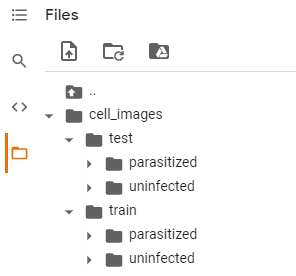

The extracted folder has different folders for train and test data which further contains the different sizes of images for parasitized and uninfected cells within the respective folder name. 

The size of all images must be the same and should be converted to 4D arrays so that they can be used as an input for the convolutional neural network. Also, we need to create the labels for both types of images to be able to train and test the model. 

Load the cell images for the training data first and then we will use the same code for the test data as well.

In [5]:
#Storing the path of the extracted "train" folder 
train_dir = '/content/drive/MyDrive/cell_images/train'
#train_dir = 'cell_images/train'

#Size of image so that each image has the same size
SIZE = 64

#Empty list to store the training images after they are converted to NumPy arrays
train_images = []

#Empty list to store the training labels (0 - uninfected, 1 - parasitized)
train_labels = []

time: 1.9 ms (started: 2022-06-02 18:24:53 +00:00)


In [6]:
#We will run the same code for "parasitized" as well as "uninfected" folders within the "train" folder
for folder_name in ['/parasitized/', '/uninfected/']:
    
    #Path of the folder
    images_path = os.listdir(train_dir + folder_name)

    for i, image_name in enumerate(images_path):
        try:
            #Opening each image using the path of that image
            image = Image.open(train_dir + folder_name + image_name)

            #Resizing each image to (64,64)
            image = image.resize((SIZE, SIZE))

            #Converting images to arrays and appending that array to the empty list defined above
            train_images.append(np.array(image))

            #Creating labels for parasitized and uninfected images
            if folder_name=='/parasitized/':
                train_labels.append(1)
            else:
                train_labels.append(0)
        except Exception:
            pass       

#Converting lists to arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

time: 8min 26s (started: 2022-06-02 18:24:53 +00:00)


In [7]:
#Storing the path of the extracted "test" folder 
test_dir = '/content/drive/MyDrive/cell_images/test'
#test_dir = 'cell_images/test'

#Size of image so that each image has the same size (it must be same as the train image size)
#SIZE = SIZE # not necessary here size I'm using the variable, SIZE

#Empty list to store the testing images after they are converted to NumPy arrays
test_images = []

#Empty list to store the testing labels (0 - uninfected, 1 - parasitized)
test_labels = []

time: 1.85 ms (started: 2022-06-02 18:33:19 +00:00)


In [8]:
#We will run the same code for "parasitized" as well as "uninfected" folders within the "test" folder
for folder_name in ['/parasitized/', '/uninfected/']:
    
    #Path of the folder
    images_path = os.listdir(test_dir + folder_name)

    for i, image_name in enumerate(images_path):
        try:
            #Opening each image using the path of that image
            image = Image.open(test_dir + folder_name + image_name)
            
            #Resizing each image to (64,64)
            image = image.resize((SIZE, SIZE))
            
            #Converting images to arrays and appending that array to the empty list defined above
            test_images.append(np.array(image))
            
            #Creating labels for parasitized and uninfected images
            if folder_name=='/parasitized/':
                test_labels.append(1)
            else:
                test_labels.append(0)
        except Exception:
            pass       

#Converting lists to arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

time: 36.6 s (started: 2022-06-02 18:33:19 +00:00)


### <b>Normalize the images</b>

In [9]:
# Make deep copies of the original arrays (for later experiments with the pre-trained Xception network)
train_images255 = copy.deepcopy(train_images)
test_images255 = copy.deepcopy(test_images)

# Normalize the train and test images by dividing it by 255 and convert them to float32 using astype function
train_images = (train_images / 255).astype('float32')
test_images = (test_images / 255).astype('float32')

time: 1.92 s (started: 2022-06-02 18:33:56 +00:00)


As we have done our preprocessing required and performed some EDA to gain some insights in our Milestone-1 so now we will try to build our model and try evaluating its performance.

### <B>One Hot Encoding on the train and test labels</b>

In [10]:
# Encoding Train Labels
train_labels=to_categorical(train_labels,2)

# Similarly let us try to encode test labels
test_labels=to_categorical(test_labels,2)

time: 2.81 ms (started: 2022-06-02 18:33:58 +00:00)


### **Base Model**

**Note:** The Base Model has been provided to give an idea about the process of the creation and evaluation of the performance of a CNN architecture. 

In [11]:
#Clearing backend
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)

random.seed(42)
tf.random.set_seed(42)

time: 28.4 ms (started: 2022-06-02 18:33:58 +00:00)


#### <b> Building the model

In [12]:
#creating sequential model
model=Sequential()
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu",input_shape=(SIZE,SIZE,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512,activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(2,activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

#### <b> Compiling the model

In [13]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

time: 10 ms (started: 2022-06-02 18:33:58 +00:00)


<b> Using Callbacks 

In [14]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

time: 1.21 ms (started: 2022-06-02 18:33:58 +00:00)


<b> Fit and train our Model

In [15]:
#Fit the model with min batch size as 32 can tune batch size to some factor of 2^power ] 
batch_size = 32
history=model.fit(train_images,train_labels,batch_size=batch_size,callbacks=callbacks,validation_split=0.2,epochs=20,verbose=1)

Epoch 1/20
628/628 [==============================] - 15s 22ms/step - loss: 0.3933 - accuracy: 0.8042 - val_loss: 0.2013 - val_accuracy: 0.8940
Epoch 2/20
628/628 [==============================] - 14s 22ms/step - loss: 0.1330 - accuracy: 0.9512 - val_loss: 0.0646 - val_accuracy: 0.9930
Epoch 3/20
628/628 [==============================] - 14s 23ms/step - loss: 0.0989 - accuracy: 0.9667 - val_loss: 0.0659 - val_accuracy: 0.9930
Epoch 4/20
628/628 [==============================] - 14s 23ms/step - loss: 0.0844 - accuracy: 0.9696 - val_loss: 0.0593 - val_accuracy: 0.9882
Epoch 5/20
628/628 [==============================] - 15s 23ms/step - loss: 0.0773 - accuracy: 0.9735 - val_loss: 0.0499 - val_accuracy: 0.9886
Epoch 6/20
628/628 [==============================] - 14s 23ms/step - loss: 0.0747 - accuracy: 0.9748 - val_loss: 0.0422 - val_accuracy: 0.9922
Epoch 7/20
628/628 [==============================] - 14s 23ms/step - loss: 0.0704 - accuracy: 0.9752 - val_loss: 0.0537 - val_accuracy:

#### <b> Evaluating the model on test data

In [16]:
accuracy = model.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

83/83 [==============================] - 1s 7ms/step - loss: 0.0670 - accuracy: 0.9837

 Test_Accuracy:- 0.9836502075195312
time: 600 ms (started: 2022-06-02 18:35:54 +00:00)


<b> Plotting the confusion matrix

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1310
           1       0.99      0.98      0.98      1320

    accuracy                           0.98      2630
   macro avg       0.98      0.98      0.98      2630
weighted avg       0.98      0.98      0.98      2630



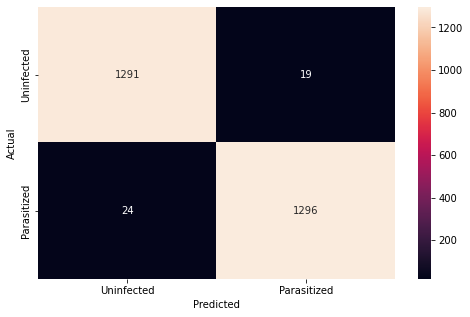

time: 800 ms (started: 2022-06-02 18:35:54 +00:00)


In [17]:
# Predict on the test images
pred = model.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<b>Plotting the train and validation curves

In [18]:
# function to plot train and validation accuracy 
def plot_accuracy(history):
    N = len(history.history["accuracy"])
    plt.figure(figsize=(7,7))
    plt.plot(np.arange(0, N), history.history["accuracy"], label="train_accuracy", ls='--')
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy", ls='--')
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

time: 3.72 ms (started: 2022-06-02 18:35:55 +00:00)


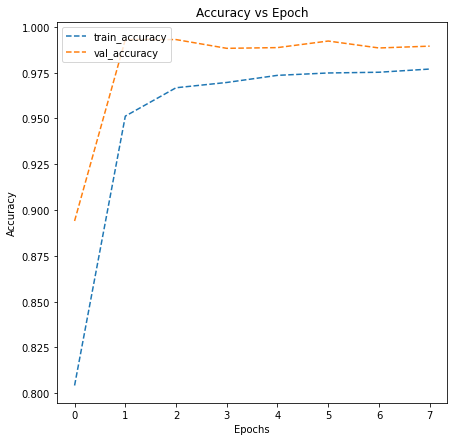

time: 188 ms (started: 2022-06-02 18:35:55 +00:00)


In [19]:
plot_accuracy(history)

* Here we can clearly observe that the training and valiation accuracy are increasing 
* And we can also notice that validation accuracy is slightly higher than the train accuracy for most of the training.
* This could indicate that the model is overfitted, or maybe the validation data just happens to be easier to predict.  
* There could be other reasons for this as well.  The validation set could be unbalanced or too small.  Or, since validation does not include the dropout factor, we have less noise and the model performs better as a results.  I vote for that one.
* Nevertheless, we should reduce the bias and variance. 

So now let's try to build another model with few more add on layers and try to check if we can try to improve the model. Therefore try to build a model by adding few layers if required and altering the activation functions.

### <b> Model 1
#### <b> Trying to improve the performance of our model by adding new layers


In [20]:
#Clearing backend
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

time: 7.62 ms (started: 2022-06-02 18:35:55 +00:00)


#### <b> Building the Model

In [21]:
#creating sequential model
model1=Sequential()

# Original Model, with layers added
model1.add(Conv2D(filters=32,kernel_size=(3,3),padding="same",input_shape=(SIZE,SIZE,3), activation="relu"))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.2))
model1.add(Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu"))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.2))
model1.add(Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu"))
model1.add(LeakyReLU(0.1))
model.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.2))

# Added layers
model1.add(Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu"))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.2))
model1.add(Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu"))
model.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.4))

model1.add(Flatten())

model1.add(Dense(512,activation="relu"))
model1.add(Dropout(0.4))
model1.add(Dense(256,activation="relu"))
model1.add(Dropout(0.4))

model1.add(Dense(2,activation="softmax"))#2 represent output layer neurons 

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

#### <b> Compiling the model

In [22]:
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

time: 15.1 ms (started: 2022-06-02 18:35:56 +00:00)


<b> Using Callbacks

In [23]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2, verbose=1),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', verbose=1, save_best_only=True)]

time: 1.04 ms (started: 2022-06-02 18:35:56 +00:00)


<b>Fit and Train the model

In [24]:
history1=model1.fit(train_images,train_labels,batch_size=32, callbacks=callbacks,  validation_split=0.2,epochs=20,verbose=1)

Epoch 1/20
627/628 [============================>.] - ETA: 0s - loss: 0.2149 - accuracy: 0.9031
Epoch 1: val_loss improved from inf to 0.06568, saving model to .mdl_wts.hdf5
628/628 [==============================] - 21s 32ms/step - loss: 0.2149 - accuracy: 0.9031 - val_loss: 0.0657 - val_accuracy: 0.9819
Epoch 2/20
627/628 [============================>.] - ETA: 0s - loss: 0.0899 - accuracy: 0.9699
Epoch 2: val_loss improved from 0.06568 to 0.05227, saving model to .mdl_wts.hdf5
628/628 [==============================] - 20s 32ms/step - loss: 0.0900 - accuracy: 0.9699 - val_loss: 0.0523 - val_accuracy: 0.9833
Epoch 3/20
627/628 [============================>.] - ETA: 0s - loss: 0.0757 - accuracy: 0.9753
Epoch 3: val_loss did not improve from 0.05227
628/628 [==============================] - 20s 32ms/step - loss: 0.0757 - accuracy: 0.9753 - val_loss: 0.0570 - val_accuracy: 0.9829
Epoch 4/20
627/628 [============================>.] - ETA: 0s - loss: 0.0739 - accuracy: 0.9759
Epoch 4: v

#### <b> Evaluating the model

In [25]:
accuracy1 = model1.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy1[1])

83/83 [==============================] - 1s 9ms/step - loss: 0.0638 - accuracy: 0.9760

 Test_Accuracy:- 0.9760456085205078
time: 791 ms (started: 2022-06-02 18:38:58 +00:00)


<b> Plotting the confusion matrix

              precision    recall  f1-score   support

           0       1.00      0.95      0.98      1310
           1       0.96      1.00      0.98      1320

    accuracy                           0.98      2630
   macro avg       0.98      0.98      0.98      2630
weighted avg       0.98      0.98      0.98      2630



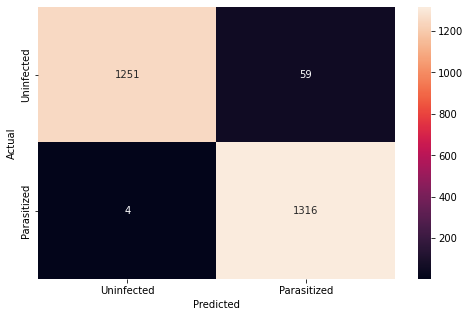

time: 973 ms (started: 2022-06-02 18:38:59 +00:00)


In [26]:
pred = model1.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<b> Plotting the Train and validation curves

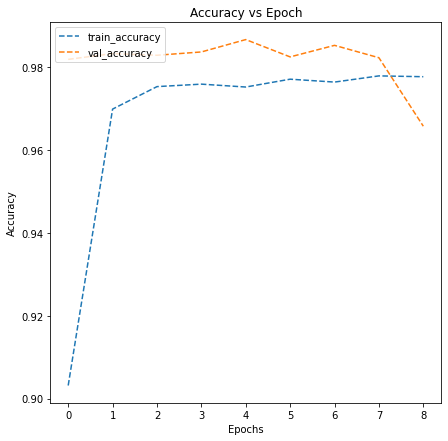

time: 184 ms (started: 2022-06-02 18:39:00 +00:00)


In [27]:
plot_accuracy(history1)

**Observations**

* Model1 is more complex than the baseline model but overall does not perform as well in some areas.  
* We can see that training accuracy surpassed validation accuracy later in the run.  At this point we were likely headed into overfitting range.
* On the plus side, Recall is higher, indicating that we are correctly finding all the parasitized cells.  But this comes at computational expense (doubling the run time), as well as lower precision.


#### <b>LeakyRelu as the activation function:</b><br>
Now we build a model with LeakyRelu as the activation function  

*  Can the model performance be improved if we change our activation function to LeakyRelu?
*  Can BatchNormalization improve our model?

The code below builds a model using BatchNormalization and using LeakyRelu as our activation function.

### <b> Model 2 with Batch Normalization

In [28]:
#Clearing backend
backend.clear_session()

#Fixing the seed for random number generators
np.random.seed(42)

random.seed(42)
tf.random.set_seed(42)

time: 8.35 ms (started: 2022-06-02 18:39:00 +00:00)


#### <b> Building the Model

In [29]:
model2 = Sequential()

model2.add(Conv2D(16, (3,3), input_shape=(SIZE, SIZE, 3), padding='same'))
model2.add(BatchNormalization())
model2.add(LeakyReLU(0.1))
model2.add(MaxPool2D(pool_size = (2, 2)))

model2.add(Conv2D(32, kernel_size = (3, 3), padding = 'same'))
model2.add(BatchNormalization())
model2.add(LeakyReLU(0.1))
model2.add(MaxPool2D(pool_size = (2, 2)))

model2.add(Conv2D(64, kernel_size = (3, 3), padding = 'same'))
model2.add(BatchNormalization())
model2.add(LeakyReLU(0.1))
model2.add(MaxPool2D(pool_size = (2, 2)))

model2.add(Flatten())

model2.add(Dense(1024, activation="relu"))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))
model2.add(Dense(2,activation="softmax"))#2 represent output layer neurons 

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 16)       64        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       1

#### <b>Compiling the model

In [30]:
adam = optimizers.Adam(learning_rate=0.001, decay = 0.001 / 64) # optimizers.Adam(learning_rate=0.001)

model2.compile(loss="binary_crossentropy", optimizer=adam, metrics = ['accuracy'])

time: 7.08 ms (started: 2022-06-02 18:39:00 +00:00)


<b> Using callbacks

In [31]:
'''
create the callbacks similarly as done in the base model
As callbacks will help us in saving our checkpoints and stopping at an accuracy where the model does  not seem to improve
'''
callbacks = [EarlyStopping(monitor='val_loss', patience=2, verbose=1),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', verbose=1, save_best_only=True)]

time: 1.25 ms (started: 2022-06-02 18:39:00 +00:00)


<b>Fit and train the model

In [32]:
history2 = model2.fit(train_images, train_labels, batch_size=32, callbacks=callbacks, validation_split=0.2, epochs=20, verbose=1)

Epoch 1/20
628/628 [==============================] - ETA: 0s - loss: 0.2315 - accuracy: 0.9104
Epoch 1: val_loss improved from inf to 0.46727, saving model to .mdl_wts.hdf5
628/628 [==============================] - 34s 52ms/step - loss: 0.2315 - accuracy: 0.9104 - val_loss: 0.4673 - val_accuracy: 0.9175
Epoch 2/20
628/628 [==============================] - ETA: 0s - loss: 0.1162 - accuracy: 0.9605
Epoch 2: val_loss improved from 0.46727 to 0.05346, saving model to .mdl_wts.hdf5
628/628 [==============================] - 31s 50ms/step - loss: 0.1162 - accuracy: 0.9605 - val_loss: 0.0535 - val_accuracy: 0.9914
Epoch 3/20
627/628 [============================>.] - ETA: 0s - loss: 0.0986 - accuracy: 0.9660
Epoch 3: val_loss improved from 0.05346 to 0.04409, saving model to .mdl_wts.hdf5
628/628 [==============================] - 31s 50ms/step - loss: 0.0990 - accuracy: 0.9658 - val_loss: 0.0441 - val_accuracy: 0.9926
Epoch 4/20
627/628 [============================>.] - ETA: 0s - loss: 0

<b>Plotting the train and validation accuracy

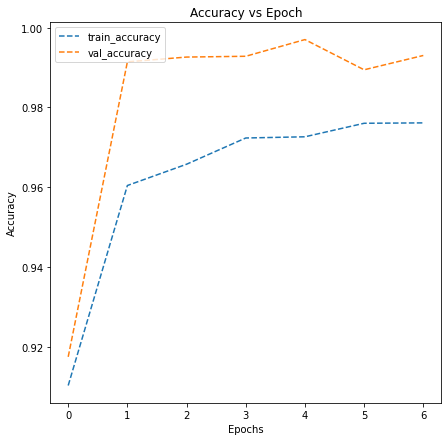

time: 179 ms (started: 2022-06-02 18:42:40 +00:00)


In [33]:
# plotting the accuracies
plot_accuracy(history2)

#### <b>Evaluating the model

In [34]:
# Evaluate the model to calculate the accuracy
accuracy2 = model2.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy2[1])

83/83 [==============================] - 1s 11ms/step - loss: 0.0568 - accuracy: 0.9825

 Test_Accuracy:- 0.9825094938278198
time: 952 ms (started: 2022-06-02 18:42:40 +00:00)


##### <b>Observations and insights: 
* Normalization and LeakyRelu mitigated the overtraining we found in previous models.  However, performance was already very good and did not improve drastically here.  (It's hard to improve beyond 0.98) 


<b> Generate the classification report and confusion matrix 

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1310
           1       0.99      0.98      0.98      1320

    accuracy                           0.98      2630
   macro avg       0.98      0.98      0.98      2630
weighted avg       0.98      0.98      0.98      2630



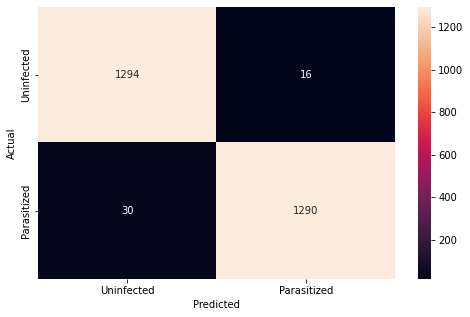

time: 1.12 s (started: 2022-06-02 18:42:41 +00:00)


In [35]:
# Classification Report and Confusion Matrix
pred = model2.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)
#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### **MODEL 3 with Data Augmentation :**<br>

* Next we build a 5-block CNN and fit it using Image Data Augmentation?
* References to image data augmentation can be seen below:
  *   [Image Augmentation for Computer Vision](https://www.mygreatlearning.com/blog/understanding-data-augmentation/)
  *   [How to Configure Image Data Augmentation in Keras?](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)





### <b>Model 3 with Data Augmentation

In [36]:
#Clearing backend
backend.clear_session()

#Fixing the seed for random number generators
np.random.seed(42)

random.seed(42)
tf.random.set_seed(42)

time: 9.43 ms (started: 2022-06-02 18:42:42 +00:00)


#### <b> Using image data generator

In [37]:
# Split the training data so that both can be used for generating augmented images
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Using ImageDataGenerator to generate images
train_datagen = ImageDataGenerator(horizontal_flip=True, 
                                  zoom_range = 0.5, rotation_range=30)
val_datagen  = ImageDataGenerator()

# Flowing training images using train_datagen generator
train_generator = train_datagen.flow(x = X_train, y = y_train, batch_size=64, seed=42, shuffle=True)     

# Flowing validation images using val_datagen generator
val_generator =  val_datagen.flow(x= X_val, y = y_val, batch_size=64, seed=42, shuffle=True)

time: 265 ms (started: 2022-06-02 18:42:42 +00:00)


#### **Think About It :**<br>

*  Check if the performance of the model can be improved by changing different parameters in the ImageDataGenerator.



#### <B>Visualizing Augmented images

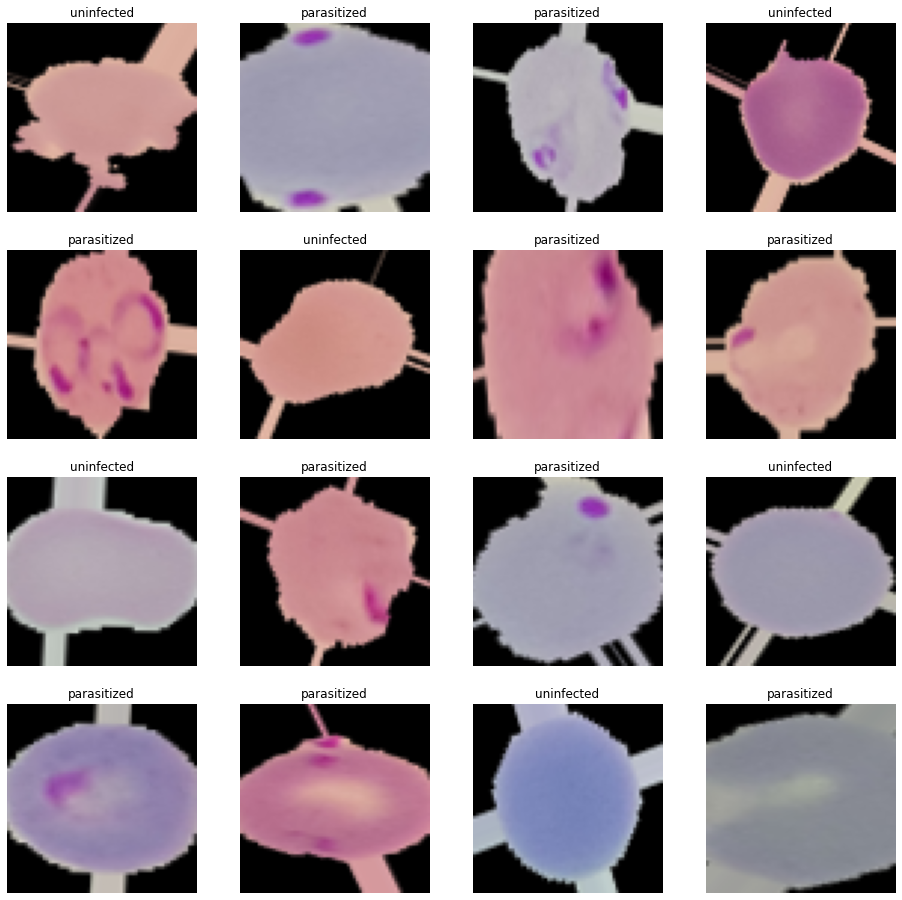

time: 1.17 s (started: 2022-06-02 18:42:43 +00:00)


In [38]:
#Creating an iterable for images and labels from the training data
images, labels = next(train_generator)

#Plotting 16 images from the training data
fig, axes = plt.subplots(4, 4, figsize = (16, 8))
fig.set_size_inches(16, 16)
for (image, label, ax) in zip(images, labels, axes.flatten()):
    ax.imshow(image)
    if label[1] == 1: 
        ax.set_title('parasitized')
    else:
        ax.set_title('uninfected')
    ax.axis('off')

##### <b>Observations and insights: 

* If we look closely, we can see that the image transformations are working as expected.  It's kind hard to tell at first, but with enough looks, you can see they are rotated, zoomed, or flipped horizontally.  Look at the bottom-right most image, for example.  This seems to be zoomed.  This is also a good example of where we find out later that augmentation does not help the models -- maybe zooming in makes it harder to detect the parasitized markers.
* The markers for parasitization a clearly still evident in the images marked as such. 

#### <b>Building the Model

In [39]:
###### 
model3 = Sequential()

# Build the model here
model3.add(Conv2D(32, (3,3), input_shape=(SIZE, SIZE, 3), padding='same'))
model3.add(LeakyReLU(0.1))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size = (2, 2)))
model3.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same'))
model3.add(LeakyReLU(0.1))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size = (2, 2)))
model3.add(BatchNormalization())
model3.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same'))
model3.add(LeakyReLU(0.1))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size = (2, 2)))
model3.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same'))
model3.add(LeakyReLU(0.1))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size = (2, 2)))
model3.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same'))
model3.add(LeakyReLU(0.1))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size = (2, 2)))
model3.add(Flatten())
model3.add(Dense(32))
model3.add(BatchNormalization())
model3.add(LeakyReLU(0.1))
model3.add(Dropout(0.5))
model3.add(Dense(2,activation="softmax"))

# use this as the optimizer
#adam = optimizers.Adam(learning_rate=0.001)
adam = optimizers.Adam(learning_rate=0.001, decay = 0.001 / 64) # optimizers.Adam(learning_rate=0.001)

model3.compile(loss="binary_crossentropy", optimizer=adam, metrics = ['accuracy'])
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 32)        0

<b>Using Callbacks

In [40]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2, verbose=1),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', verbose=1, save_best_only=True)]

time: 1.02 ms (started: 2022-06-02 18:42:44 +00:00)


<b> Fit and Train the model

In [41]:
batch_size = 32
history3aug = model3.fit(train_generator, 
                                  validation_data=val_generator,
                                  batch_size=batch_size,callbacks=callbacks,
                                  epochs=20,verbose=1)

Epoch 1/20
314/314 [==============================] - ETA: 0s - loss: 0.3573 - accuracy: 0.8526
Epoch 1: val_loss improved from inf to 0.57938, saving model to .mdl_wts.hdf5
314/314 [==============================] - 32s 97ms/step - loss: 0.3573 - accuracy: 0.8526 - val_loss: 0.5794 - val_accuracy: 0.6473
Epoch 2/20
314/314 [==============================] - ETA: 0s - loss: 0.1741 - accuracy: 0.9439
Epoch 2: val_loss improved from 0.57938 to 0.12660, saving model to .mdl_wts.hdf5
314/314 [==============================] - 30s 96ms/step - loss: 0.1741 - accuracy: 0.9439 - val_loss: 0.1266 - val_accuracy: 0.9586
Epoch 3/20
314/314 [==============================] - ETA: 0s - loss: 0.1598 - accuracy: 0.9477
Epoch 3: val_loss improved from 0.12660 to 0.06982, saving model to .mdl_wts.hdf5
314/314 [==============================] - 30s 96ms/step - loss: 0.1598 - accuracy: 0.9477 - val_loss: 0.0698 - val_accuracy: 0.9777
Epoch 4/20
314/314 [==============================] - ETA: 0s - loss: 0

####<B>Evaluating the model

<b>Plot the train and validation accuracy

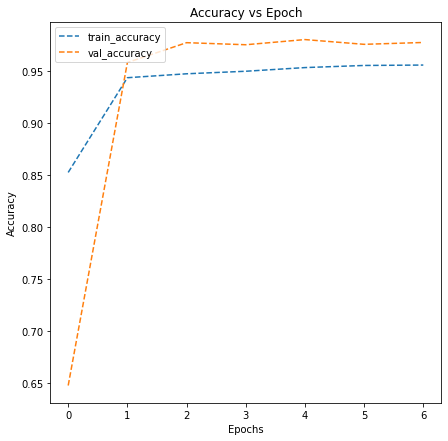

time: 185 ms (started: 2022-06-02 18:46:18 +00:00)


In [42]:
# plotting the accuracies
plot_accuracy(history3aug)

In [43]:
# Evaluating the model on test data
accuracy3aug = model3.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy3aug[1])


83/83 [==============================] - 1s 13ms/step - loss: 0.0698 - accuracy: 0.9806

 Test_Accuracy:- 0.980608344078064
time: 1.29 s (started: 2022-06-02 18:46:18 +00:00)


<B>Plotting the classification report and confusion matrix

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1310
           1       0.98      0.98      0.98      1320

    accuracy                           0.98      2630
   macro avg       0.98      0.98      0.98      2630
weighted avg       0.98      0.98      0.98      2630



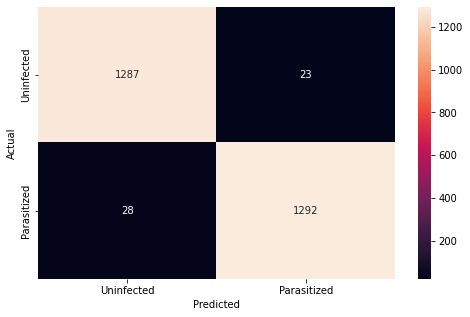

time: 1.22 s (started: 2022-06-02 18:46:19 +00:00)


In [44]:
pred = model3.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Observations**

* Using augmented data with this new model (Model 3) did not provide significant improvement.  However, it's hard to improve measures of success that were already very high.
* **Of note, the training and validation accuracy levels were closer together.**
* Later in this notebook, we fit this same model on the original training data.  This actually performed better than with the augmented data.  
* Results were pretty good overall.

# **Model2 with Augmented Data**
- This model below is the same model2 we ran with the original training data, but now with the augmented data.  Apples to Apples comparison

In [45]:
# #Clearing backend
# backend.clear_session()

# #Fixing the seed for random number generators
# np.random.seed(42)

# random.seed(42)
# tf.random.set_seed(42)

time: 1.06 ms (started: 2022-06-02 18:46:20 +00:00)


**Note** In order to reuse Model2, the code below re-randomizes the weights.  Note that this may be a different random distribution than the original Model2 run, but I'm not sure.
* This was done to re-set the model and re-train it so we can get a complete apples to apples comparison, vice starting with the Model2 pre-trained weights.

In [46]:
from keras.initializers import glorot_uniform 
import keras.backend as K

initial_weights = model2.get_weights()

new_weights = [np.random.permutation(w.flat).reshape(w.shape) for w in initial_weights]
    
#new_weights = [k_eval(glorot_uniform()(w.shape)) for w in initial_weights]

model2.set_weights(new_weights)

#model2.compile(loss="binary_crossentropy", optimizer=adam, metrics = ['accuracy'])

time: 186 ms (started: 2022-06-02 18:46:20 +00:00)


In [47]:
adam = optimizers.Adam(learning_rate=0.001, decay = 0.001 / 64) # optimizers.Adam(learning_rate=0.001)
'''
create the callbacks similarly as done in the base model
As callbacks will help us in saving our checkpoints and stopping at an accuracy where the model does  not seem to improve
'''
callbacks = [EarlyStopping(monitor='val_loss', patience=2, verbose=1),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', verbose=1, save_best_only=True)]

time: 2.15 ms (started: 2022-06-02 18:46:21 +00:00)


In [48]:
batch_size = 32
history2aug = model2.fit(train_generator, 
                                  validation_data=val_generator,
                                  batch_size=batch_size,callbacks=callbacks,
                                  epochs=20,verbose=1)

Epoch 1/20
314/314 [==============================] - ETA: 0s - loss: 0.3888 - accuracy: 0.8181
Epoch 1: val_loss improved from inf to 4.41820, saving model to .mdl_wts.hdf5
314/314 [==============================] - 29s 92ms/step - loss: 0.3888 - accuracy: 0.8181 - val_loss: 4.4182 - val_accuracy: 0.5806
Epoch 2/20
314/314 [==============================] - ETA: 0s - loss: 0.1791 - accuracy: 0.9383
Epoch 2: val_loss improved from 4.41820 to 0.12473, saving model to .mdl_wts.hdf5
314/314 [==============================] - 29s 92ms/step - loss: 0.1791 - accuracy: 0.9383 - val_loss: 0.1247 - val_accuracy: 0.9622
Epoch 3/20
314/314 [==============================] - ETA: 0s - loss: 0.1538 - accuracy: 0.9457
Epoch 3: val_loss improved from 0.12473 to 0.07232, saving model to .mdl_wts.hdf5
314/314 [==============================] - 29s 92ms/step - loss: 0.1538 - accuracy: 0.9457 - val_loss: 0.0723 - val_accuracy: 0.9739
Epoch 4/20
314/314 [==============================] - ETA: 0s - loss: 0

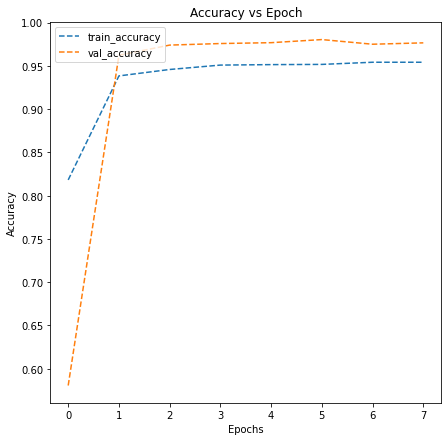

time: 208 ms (started: 2022-06-02 18:50:13 +00:00)


In [49]:
# plotting the accuracies
plot_accuracy(history2aug)

In [50]:
# Evaluating the model on test data
accuracy2aug = model2.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy2aug[1])

83/83 [==============================] - 1s 10ms/step - loss: 0.0708 - accuracy: 0.9817

 Test_Accuracy:- 0.9817490577697754
time: 979 ms (started: 2022-06-02 18:50:13 +00:00)


              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1310
           1       0.98      0.98      0.98      1320

    accuracy                           0.98      2630
   macro avg       0.98      0.98      0.98      2630
weighted avg       0.98      0.98      0.98      2630



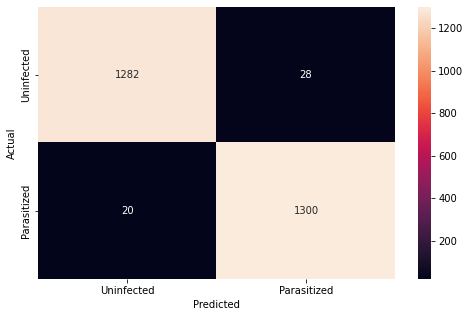

time: 1.04 s (started: 2022-06-02 18:50:14 +00:00)


In [51]:
pred = model2.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Observations**  
* Again, training model2 again with augmented data did not provide significant improvments.  In the future, it would be good to get another pair of eyes on this code to consider options for improving performance.  For example, different batch sizes or more extensive data samples.
* Also again, the training and validation lines were closer in the accuracy chart.
* There are several hyperparameters for all these models that could be adjusted with more time, such as the amount of batch normalization and the dropout rates.  We could also adjust the number of layers in the classification architecture.

<b> Now let us try to use a pretrained model like VGG16 and check how it performs on our data.

### **Pre-trained model (VGG16)**

In [52]:
#Clearing backend
backend.clear_session()
#Fixing the seed for random number generators
np.random.seed(42)

random.seed(42)
tf.random.set_seed(42)

time: 16.5 ms (started: 2022-06-02 18:50:15 +00:00)


In [53]:
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(SIZE,SIZE,3))
vgg.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [54]:
transfer_layer = vgg.get_layer('block5_pool')
vgg.trainable=False

# Add classification layers on top of it  
x = Flatten()(transfer_layer.output) #Flatten the output from the 3rd block of the VGG16 model
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Similarly add a dense layer with 128 neurons
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Add a dense layer with 64 neurons
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

pred = Dense(2, activation='softmax')(x)

model4vgg = Model(vgg.input, pred) #Initializing the model

time: 102 ms (started: 2022-06-02 18:50:16 +00:00)


####<b>Compiling the model

In [55]:
# use this as the optimizer
adam = optimizers.Adam(learning_rate=0.001)

# Compiling the model 
model4vgg.compile(loss="binary_crossentropy", optimizer=adam, metrics = ['accuracy'])
model4vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

<b> using callbacks

In [56]:
# Adding Callbacks to the model
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', verbose=1, save_best_only=True)]

time: 1.2 ms (started: 2022-06-02 18:50:16 +00:00)


<b>Fit and Train the model

In [57]:
batch_size = 32
#Fitting the model and running the model for 10 epochs
history4vgg = model4vgg.fit(
           train_images, train_labels,
           epochs=10,
           callbacks=callbacks,
           batch_size=batch_size,
           validation_split=0.2,
           verbose=1
)


Epoch 1/10
628/628 [==============================] - ETA: 0s - loss: 0.3201 - accuracy: 0.8794
Epoch 1: val_loss improved from inf to 0.13928, saving model to .mdl_wts.hdf5
628/628 [==============================] - 74s 115ms/step - loss: 0.3201 - accuracy: 0.8794 - val_loss: 0.1393 - val_accuracy: 0.9434
Epoch 2/10
628/628 [==============================] - ETA: 0s - loss: 0.2205 - accuracy: 0.9154
Epoch 2: val_loss improved from 0.13928 to 0.10135, saving model to .mdl_wts.hdf5
628/628 [==============================] - 73s 116ms/step - loss: 0.2205 - accuracy: 0.9154 - val_loss: 0.1014 - val_accuracy: 0.9727
Epoch 3/10
628/628 [==============================] - ETA: 0s - loss: 0.2060 - accuracy: 0.9194
Epoch 3: val_loss did not improve from 0.10135
628/628 [==============================] - 74s 117ms/step - loss: 0.2060 - accuracy: 0.9194 - val_loss: 0.1557 - val_accuracy: 0.9566
Epoch 4/10
628/628 [==============================] - ETA: 0s - loss: 0.1884 - accuracy: 0.9261
Epoch 4

<b>Plot the train and validation accuracy

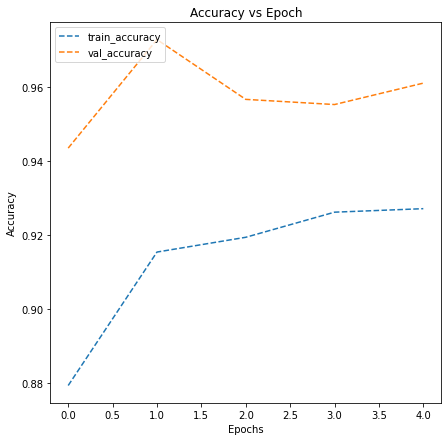

time: 180 ms (started: 2022-06-02 18:56:20 +00:00)


In [58]:
# plotting the accuracies
plot_accuracy(history4vgg)

##### **Observations and insights:**

*   Initial results from the VGG transfer learning model are not great, actually significantly worse than the other models. 
*  Looking at the training and validation curves, we can see that the validation results are higher than the training results.  This might could be improved upon with hyperparameter adjustments, architecture changes, and/or data augmentation.  Also, I'm not sure we need 3 classification layers.
* I had patience=3 on this one, so perhaps this trains extremely fast before getting into overfit range.

####<b> Evaluating the model

In [59]:
# Evaluating the model on test data
accuracy4vgg = model4vgg.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy4vgg[1])

83/83 [==============================] - 7s 89ms/step - loss: 0.1650 - accuracy: 0.9354

 Test_Accuracy:- 0.9353612065315247
time: 7.43 s (started: 2022-06-02 18:56:20 +00:00)


<b>Plotting the classification report and confusion matrix

              precision    recall  f1-score   support

           0       0.96      0.91      0.93      1310
           1       0.91      0.96      0.94      1320

    accuracy                           0.94      2630
   macro avg       0.94      0.94      0.94      2630
weighted avg       0.94      0.94      0.94      2630



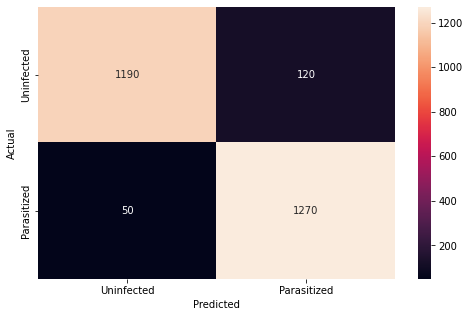

time: 7.61 s (started: 2022-06-02 18:56:28 +00:00)


In [60]:
# Plot the confusion matrix and generate a classification report for the model
pred = model4vgg.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)
#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [61]:
#Clearing backend
backend.clear_session()
#Fixing the seed for random number generators
np.random.seed(42)

random.seed(42)
tf.random.set_seed(42)

time: 10.4 ms (started: 2022-06-02 18:56:35 +00:00)


**Observation**
* Performance is quite a bit less than in previous models.  

# **Re-train VGG, this time with augmented data**

In [62]:
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(SIZE,SIZE,3))
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [63]:
transfer_layer = vgg.get_layer('block5_pool')
vgg.trainable=False

# Add classification layers on top of it  

# add new classifier layers
x = Flatten()(transfer_layer.output) #Flatten the output from the 3rd block of the VGG16 model
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Similarly add a dense layer with 128 neurons
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Add a dense layer with 64 neurons
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

pred = Dense(2, activation='softmax')(x)

model_vggaug = Model(vgg.input, pred) #Initializing the model

time: 88.9 ms (started: 2022-06-02 18:56:36 +00:00)


In [64]:
# use this as the optimizer, note the decay
adam = optimizers.Adam(lr = 0.001, decay = 0.001 / 64)

# Compiling the model 
model_vggaug.compile(loss="binary_crossentropy", optimizer=adam, metrics = ['accuracy'])
model_vggaug.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [65]:
# Adding Callbacks to the model
callbacks = [EarlyStopping(monitor='val_loss', patience=2, verbose=1),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', verbose=1, save_best_only=True)]

time: 1.83 ms (started: 2022-06-02 18:56:36 +00:00)


In [66]:
batch_size = 64
history_vggaug = model_vggaug.fit(
            train_generator, validation_data=val_generator,
            epochs=10,
            callbacks=callbacks,
            batch_size=batch_size,
            #validation_split=0.2,
            verbose=1
)

Epoch 1/10
314/314 [==============================] - ETA: 0s - loss: 0.4688 - accuracy: 0.8018
Epoch 1: val_loss improved from inf to 0.24736, saving model to .mdl_wts.hdf5
314/314 [==============================] - 67s 208ms/step - loss: 0.4688 - accuracy: 0.8018 - val_loss: 0.2474 - val_accuracy: 0.9006
Epoch 2/10
314/314 [==============================] - ETA: 0s - loss: 0.3494 - accuracy: 0.8556
Epoch 2: val_loss improved from 0.24736 to 0.20420, saving model to .mdl_wts.hdf5
314/314 [==============================] - 66s 209ms/step - loss: 0.3494 - accuracy: 0.8556 - val_loss: 0.2042 - val_accuracy: 0.9209
Epoch 3/10
314/314 [==============================] - ETA: 0s - loss: 0.3212 - accuracy: 0.8664
Epoch 3: val_loss improved from 0.20420 to 0.19257, saving model to .mdl_wts.hdf5
314/314 [==============================] - 67s 213ms/step - loss: 0.3212 - accuracy: 0.8664 - val_loss: 0.1926 - val_accuracy: 0.9237
Epoch 4/10
314/314 [==============================] - ETA: 0s - loss

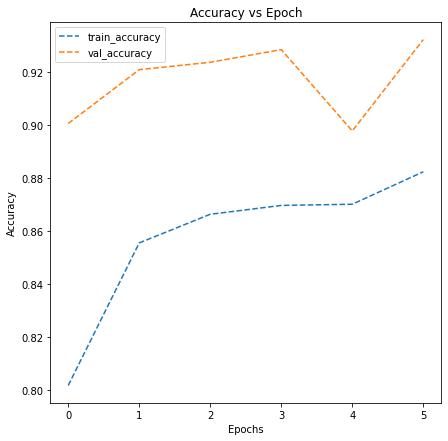

time: 440 ms (started: 2022-06-02 19:03:14 +00:00)


In [67]:
# plotting the accuracies
plot_accuracy(history_vggaug)

In [68]:
# Evaluating the model on test data
accuracy_vggaug = model_vggaug.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy_vggaug[1])

83/83 [==============================] - 8s 92ms/step - loss: 0.2284 - accuracy: 0.9133

 Test_Accuracy:- 0.9133079648017883
time: 7.9 s (started: 2022-06-02 19:03:15 +00:00)


              precision    recall  f1-score   support

           0       0.96      0.86      0.91      1310
           1       0.88      0.96      0.92      1320

    accuracy                           0.91      2630
   macro avg       0.92      0.91      0.91      2630
weighted avg       0.92      0.91      0.91      2630



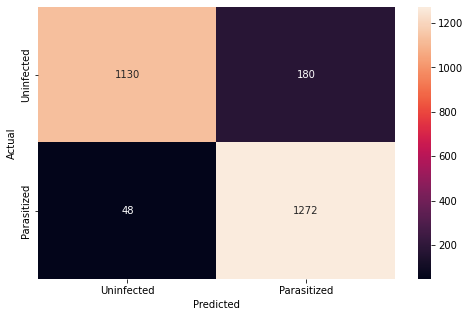

time: 7.66 s (started: 2022-06-02 19:03:23 +00:00)


In [69]:
# Plot the confusion matrix and generate a classification report for the model
pred = model_vggaug.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)
#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**VGG with data augmentaiton Observations**
* Again, data augmentation resulted in lesser performance that non-augmented data.  It almost seems like the VGG CNN is a bit too sensitive to training.

# Model3 **without** augmented data.
* We're doing this here because the first Model3 run was with augmented data.
* This will allow us to make an apples-to-apples comparison with Model3.

In [70]:
#Clearing backend
backend.clear_session()
#Fixing the seed for random number generators
np.random.seed(42)

random.seed(42)
tf.random.set_seed(42)

time: 12.6 ms (started: 2022-06-02 19:03:30 +00:00)


* For this run of Model3, we re-randomize the model 3 weights so we can train from scratch with a fresh version of the model.  It's not impossible that this could results in better starting random weights, but I don't think so.

In [71]:
# Re-initialize model3 weights
initial_weights = model3.get_weights()

new_weights = [np.random.permutation(w.flat).reshape(w.shape) for w in initial_weights]
    
#new_weights = [k_eval(glorot_uniform()(w.shape)) for w in initial_weights]

model3.set_weights(new_weights)

time: 14.4 ms (started: 2022-06-02 19:03:30 +00:00)


In [72]:
history3c = model3.fit(train_images,train_labels,batch_size=32,callbacks=callbacks,validation_split=0.2,epochs=20,verbose=1)

Epoch 1/20
628/628 [==============================] - ETA: 0s - loss: 0.2627 - accuracy: 0.9000
Epoch 1: val_loss improved from 0.17734 to 0.06983, saving model to .mdl_wts.hdf5
628/628 [==============================] - 32s 49ms/step - loss: 0.2627 - accuracy: 0.9000 - val_loss: 0.0698 - val_accuracy: 0.9827
Epoch 2/20
627/628 [============================>.] - ETA: 0s - loss: 0.0884 - accuracy: 0.9724
Epoch 2: val_loss improved from 0.06983 to 0.05764, saving model to .mdl_wts.hdf5
628/628 [==============================] - 31s 49ms/step - loss: 0.0884 - accuracy: 0.9724 - val_loss: 0.0576 - val_accuracy: 0.9916
Epoch 3/20
628/628 [==============================] - ETA: 0s - loss: 0.0766 - accuracy: 0.9748
Epoch 3: val_loss improved from 0.05764 to 0.03907, saving model to .mdl_wts.hdf5
628/628 [==============================] - 31s 50ms/step - loss: 0.0766 - accuracy: 0.9748 - val_loss: 0.0391 - val_accuracy: 0.9890
Epoch 4/20
627/628 [============================>.] - ETA: 0s - los

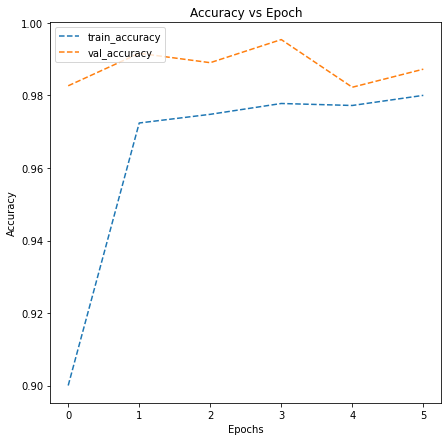

time: 190 ms (started: 2022-06-02 19:06:38 +00:00)


In [73]:
# plotting the accuracies
plot_accuracy(history3c)

In [74]:
# Evaluating the model on test data
accuracy3c = model3.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy3c[1])

83/83 [==============================] - 1s 12ms/step - loss: 0.0406 - accuracy: 0.9867

 Test_Accuracy:- 0.9866920113563538
time: 1.1 s (started: 2022-06-02 19:06:39 +00:00)


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1310
           1       0.99      0.99      0.99      1320

    accuracy                           0.99      2630
   macro avg       0.99      0.99      0.99      2630
weighted avg       0.99      0.99      0.99      2630



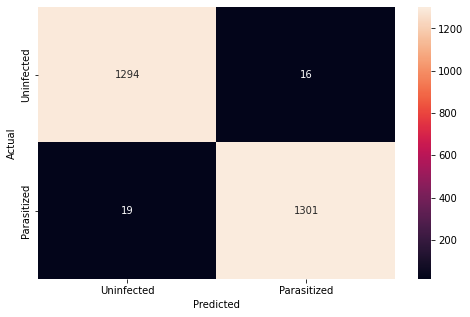

time: 1.16 s (started: 2022-06-02 19:06:40 +00:00)


In [75]:
pred = model3.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)
#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Observations**
# * **Model3** with un-altered data, normalization, and LeakRelu, provides the best performance in all areas, and the computational expense and complexity are not overly taxing.

### <b>Converting RGB to HSV of Images using OpenCV
    
#### <b> Converting the train data from RGB to HSV

In [76]:
gfx=[]   # to hold the HSV image array
for i in np.arange(0,len(train_images),1):
    a=cv2.cvtColor(train_images[i],cv2.COLOR_BGR2HSV)
    gfx.append(a)
gfx=np.array(gfx)

time: 979 ms (started: 2022-06-02 19:06:41 +00:00)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


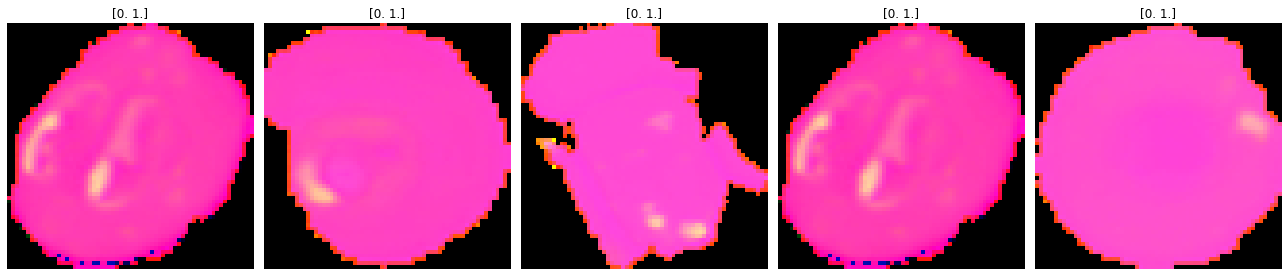

time: 9.68 s (started: 2022-06-02 19:06:42 +00:00)


In [77]:
viewimage=np.random.randint(1,100,5)
fig,ax=plt.subplots(1,5,figsize=(18,18))
for t,i in zip(range(5),viewimage):
    Title=train_labels[i]
    ax[t].set_title(Title)
    ax[t].imshow(gfx[i])
    ax[t].set_axis_off()
    fig.tight_layout()

In [78]:
gfx_test=[]   # to hold the HSV image array
for i in np.arange(0,len(test_images),1):
    a=cv2.cvtColor(test_images[i],cv2.COLOR_BGR2HSV)
    gfx_test.append(a)
gfx_test=np.array(gfx_test)

time: 111 ms (started: 2022-06-02 19:06:52 +00:00)


####<b> Converting the test data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


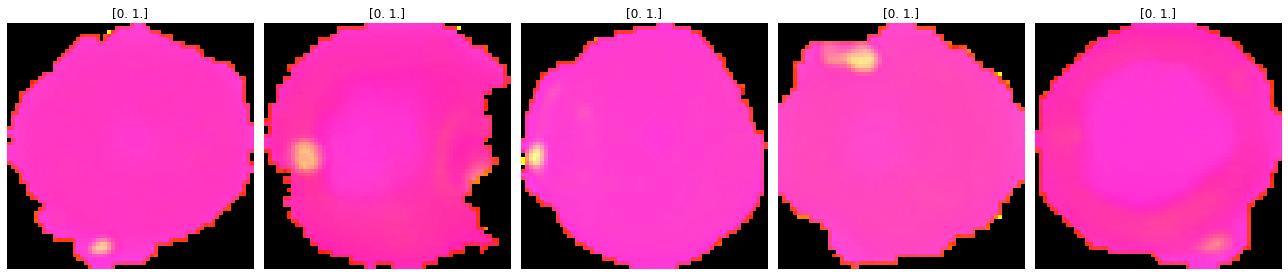

time: 441 ms (started: 2022-06-02 19:06:52 +00:00)


In [79]:
# Similarly you can visualize for the images in the test data
viewimage=np.random.randint(1,100,5)
fig,ax=plt.subplots(1,5,figsize=(18,18))
for t,i in zip(range(5),viewimage):
    Title=test_labels[i]
    ax[t].set_title(Title)
    ax[t].imshow(gfx_test[i])
    ax[t].set_axis_off()
    fig.tight_layout()

**Note**
* Below, we created data augmentation generators with the HSV images.

In [80]:
X_train, X_val, y_train, y_val = train_test_split(gfx, train_labels, test_size=0.2, random_state=42)

# Using ImageDataGenerator to generate images
train_datagenHSV = ImageDataGenerator(horizontal_flip=True, rotation_range=30) # take out zoom
val_datagenHSV  = ImageDataGenerator()

# Flowing training images using train_datagen generator
train_generatorHSV = train_datagenHSV.flow(x = X_train, y = y_train, batch_size=64, seed=42, shuffle=False)     

# Flowing validation images using val_datagen generator
val_generatorHSV =  val_datagenHSV.flow(x= X_val, y = y_val, batch_size=64, seed=42, shuffle=False)

time: 522 ms (started: 2022-06-02 19:06:52 +00:00)


In [81]:
# callbacks = [EarlyStopping(monitor='val_loss', patience=3),
#              ModelCheckpoint('.mdl_wts.hdfb5', monitor='val_loss', verbose=1, save_best_only=True)]

time: 773 µs (started: 2022-06-02 19:06:53 +00:00)


# Re-create model 3, but with HSV images this time, after rebuilding model 3 from scratch.  (I could have re-randomize weights of the existing model3, but this is a fresh version of it instead).

In [82]:
#Clearing backend
backend.clear_session()
#Fixing the seed for random number generators
np.random.seed(42)

random.seed(42)
tf.random.set_seed(42)

time: 11.2 ms (started: 2022-06-02 19:06:53 +00:00)


In [83]:
###### Rebuild and slightly modify model 3 for HSV and data augmentation
model3baughsv = Sequential()

# Build the model here
model3baughsv.add(Conv2D(32, (3,3), input_shape=(SIZE, SIZE, 3), padding='same'))
model3baughsv.add(LeakyReLU(0.1))
model3baughsv.add(BatchNormalization())
model3baughsv.add(MaxPool2D(pool_size = (2, 2)))
model3baughsv.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same'))
model3baughsv.add(LeakyReLU(0.1))
model3baughsv.add(BatchNormalization())
model3baughsv.add(MaxPool2D(pool_size = (2, 2)))
model3baughsv.add(BatchNormalization())
model3baughsv.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same'))
model3baughsv.add(LeakyReLU(0.1))
model3baughsv.add(BatchNormalization())
model3baughsv.add(MaxPool2D(pool_size = (2, 2)))
model3baughsv.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same'))
model3baughsv.add(LeakyReLU(0.1))
model3baughsv.add(BatchNormalization())
model3baughsv.add(MaxPool2D(pool_size = (2, 2)))
model3baughsv.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same'))
model3baughsv.add(LeakyReLU(0.1))
model3baughsv.add(BatchNormalization())
model3baughsv.add(MaxPool2D(pool_size = (2, 2)))
model3baughsv.add(Flatten())
model3baughsv.add(Dense(32))
model3baughsv.add(BatchNormalization())
model3baughsv.add(LeakyReLU(0.1))
model3baughsv.add(Dropout(0.5))
model3baughsv.add(Dense(2,activation="softmax"))

# use this as the optimizer
#adam = optimizers.Adam(learning_rate=0.001)

model3baughsv.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 32)        0

In [84]:
# use this as the optimizer
adam = optimizers.Adam(learning_rate=0.001, decay = 0.001 / 64) # optimizers.Adam(learning_rate=0.001)

model3baughsv.compile(loss="binary_crossentropy", optimizer=adam, metrics = ['accuracy'])

time: 19.9 ms (started: 2022-06-02 19:06:53 +00:00)


In [85]:
# Callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=2, verbose=1),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', verbose=1, save_best_only=True)]

# Fit and Train the model on the HSV image generators
batch_size = 64
history3baughsv = model3baughsv.fit(train_generatorHSV, 
                                  validation_data=val_generatorHSV,
                                  batch_size=batch_size,callbacks=callbacks,
                                  epochs=20,verbose=1)

Epoch 1/20
314/314 [==============================] - ETA: 0s - loss: 0.6440 - accuracy: 0.6487
Epoch 1: val_loss improved from inf to 1.15731, saving model to .mdl_wts.hdf5
314/314 [==============================] - 31s 96ms/step - loss: 0.6440 - accuracy: 0.6487 - val_loss: 1.1573 - val_accuracy: 0.5091
Epoch 2/20
314/314 [==============================] - ETA: 0s - loss: 0.3825 - accuracy: 0.8160
Epoch 2: val_loss did not improve from 1.15731
314/314 [==============================] - 30s 94ms/step - loss: 0.3825 - accuracy: 0.8160 - val_loss: 1.2122 - val_accuracy: 0.4919
Epoch 3/20
314/314 [==============================] - ETA: 0s - loss: 0.1847 - accuracy: 0.9356
Epoch 3: val_loss improved from 1.15731 to 0.31584, saving model to .mdl_wts.hdf5
314/314 [==============================] - 30s 94ms/step - loss: 0.1847 - accuracy: 0.9356 - val_loss: 0.3158 - val_accuracy: 0.8769
Epoch 4/20
314/314 [==============================] - ETA: 0s - loss: 0.1207 - accuracy: 0.9621
Epoch 4: v

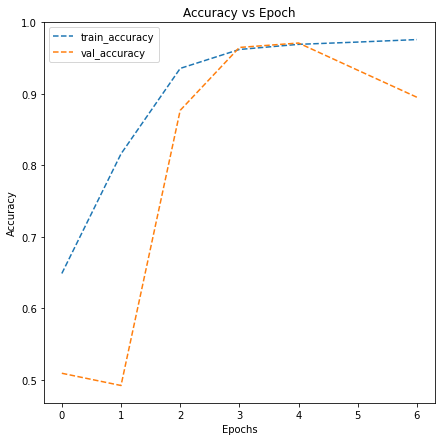

time: 182 ms (started: 2022-06-02 19:10:21 +00:00)


In [86]:
# plotting the accuracies
plot_accuracy(history3baughsv)

In [87]:
# Evaluating the model on test data
accuracy3baughsv = model3baughsv.evaluate(gfx_test, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy3baughsv[1])


83/83 [==============================] - 1s 12ms/step - loss: 0.2568 - accuracy: 0.9278

 Test_Accuracy:- 0.927756667137146
time: 1.23 s (started: 2022-06-02 19:10:21 +00:00)


              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1310
           1       1.00      0.86      0.92      1320

    accuracy                           0.93      2630
   macro avg       0.94      0.93      0.93      2630
weighted avg       0.94      0.93      0.93      2630



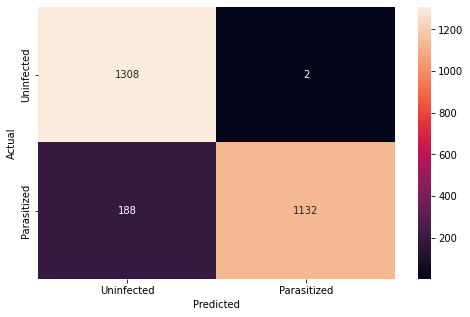

time: 1.17 s (started: 2022-06-02 19:10:23 +00:00)


In [88]:
pred = model3baughsv.predict(gfx_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)
#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Observations**
* Using HSV transformed images did not provide a significant improvement, as compared to the baseline Model3.  However the baseline Model3 is already the best model, as we'll see later in this notebook so that doesn't necesarily mean that HSV didn't have an effect.

# Transfer learning with Xception Net
* This time we perform transfer learning with the well-known Xception CNN architecture, and pret-trained weights on imagenet.
* Much of this code was copied directly from the link below, and some additional code was added, deleted, modified for our specific project.

https://keras.io/guides/transfer_learning/

In [89]:
#Clearing backend
backend.clear_session()
#Fixing the seed for random number generators
np.random.seed(42)

random.seed(42)
tf.random.set_seed(42)

time: 11.3 ms (started: 2022-06-02 19:10:24 +00:00)


**Note** 
* Since Xception requires Images to be at least 70x70, I re-instituted the training and test arrays to be SIZE = 150.

In [90]:
#Storing the path of the extracted "train" folder 
train_dir = '/content/cell_images/train'
#train_dir = 'cell_images/train'

#Size of image so that each image has the same size
SIZE = 150 # 64

#Empty list to store the training images after they are converted to NumPy arrays
train_images = []

#Empty list to store the training labels (0 - uninfected, 1 - parasitized)
train_labels = []

time: 1.92 ms (started: 2022-06-02 19:10:24 +00:00)


In [91]:
#We will run the same code for "parasitized" as well as "uninfected" folders within the "train" folder
for folder_name in ['/parasitized/', '/uninfected/']:
    
    #Path of the folder
    images_path = os.listdir(train_dir + folder_name)

    for i, image_name in enumerate(images_path):
        try:
            #Opening each image using the path of that image
            image = Image.open(train_dir + folder_name + image_name)

            #Resizing each image to (64,64)
            image = image.resize((SIZE, SIZE))

            #Converting images to arrays and appending that array to the empty list defined above
            train_images.append(np.array(image))

            #Creating labels for parasitized and uninfected images
            if folder_name=='/parasitized/':
                train_labels.append(1)
            else:
                train_labels.append(0)
        except Exception:
            pass       

#Converting lists to arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

time: 37.9 s (started: 2022-06-02 19:10:24 +00:00)


In [92]:
#Storing the path of the extracted "test" folder 
test_dir = '/content/cell_images/test'
#test_dir = 'cell_images/test'

#Size of image so that each image has the same size (it must be same as the train image size)
#SIZE = SIZE

#Empty list to store the testing images after they are converted to NumPy arrays
test_images = []

#Empty list to store the testing labels (0 - uninfected, 1 - parasitized)
test_labels = []

time: 1.83 ms (started: 2022-06-02 19:11:02 +00:00)


In [93]:
#We will run the same code for "parasitized" as well as "uninfected" folders within the "test" folder
for folder_name in ['/parasitized/', '/uninfected/']:
    
    #Path of the folder
    images_path = os.listdir(test_dir + folder_name)

    for i, image_name in enumerate(images_path):
        try:
            #Opening each image using the path of that image
            image = Image.open(test_dir + folder_name + image_name)
            
            #Resizing each image to (64,64)
            image = image.resize((SIZE, SIZE))
            
            #Converting images to arrays and appending that array to the empty list defined above
            test_images.append(np.array(image))
            
            #Creating labels for parasitized and uninfected images
            if folder_name=='/parasitized/':
                test_labels.append(1)
            else:
                test_labels.append(0)
        except Exception:
            pass       

#Converting lists to arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

time: 9.53 s (started: 2022-06-02 19:11:02 +00:00)


* This could done different ways, but this time we don't use the normalized image data as input.  Normalization is done within a scaling layer within the overall network architecture (see code further down). 

In [94]:
# Make deep copies of the original arrays (for later experiments such as Xception)
train_images255 = copy.deepcopy(train_images)
test_images255 = copy.deepcopy(test_images)

# Normalize the train and test images by dividing it by 255 and convert them to float32 using astype function
train_images = (train_images / 255).astype('float32')
test_images = (test_images / 255).astype('float32')

time: 24.6 s (started: 2022-06-02 19:11:11 +00:00)


**Note**
* For this, we don't treat the labels as categorical, so we can just use the data as is (saving a copy below).

In [95]:
# Encoding Train Labels
train_labels255=copy.deepcopy(train_labels)

# Similarly let us try to encode test labels
test_labels255=copy.deepcopy(test_labels)

time: 1.66 ms (started: 2022-06-02 19:11:36 +00:00)


In [96]:
# Encoding Train Labels
train_labels=to_categorical(train_labels,2)

# Similarly let us try to encode test labels
test_labels=to_categorical(test_labels,2)

time: 2.58 ms (started: 2022-06-02 19:11:36 +00:00)


### Create new data augmentation generators for the non-normalized VGG data

In [97]:
# Split the training data so that both can be used for generating augmented images
X_train, X_val, y_train, y_val = train_test_split(train_images255, train_labels255, test_size=0.2, random_state=42)

# Using ImageDataGenerator to generate images
train_datagen255 = ImageDataGenerator(horizontal_flip=True, rotation_range=30)  # no zooming
val_datagen255  = ImageDataGenerator()

# Flowing training images using train_datagen generator
train_generator255 = train_datagen255.flow(x = X_train, y = y_train, batch_size=64, seed=42, shuffle=False)     

# Flowing validation images using val_datagen generator
val_generator255 =  val_datagen255.flow(x= X_val, y = y_val, batch_size=64, seed=42, shuffle=False)

time: 1.35 s (started: 2022-06-02 19:11:36 +00:00)


In [98]:
# Load the Xception model with imagenet and freeze it
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(SIZE, SIZE, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

base_model.summary()

83697664/83683744 [==============================] - 0s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 74, 74, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                          

In [99]:
# Create new model on top
inputs = keras.Input(shape=(SIZE, SIZE, 3))
data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)  # this is in addition to our input augmentation data

x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
modelX = keras.Model(inputs, outputs)

modelX.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [100]:
#Train the top layer
modelX.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', verbose=1, save_best_only=True)]

batch_size = 64
epochs = 20
modelX.fit(train_generator255, validation_data=val_generator255, epochs=epochs, verbose=1, callbacks=callbacks)

Epoch 1/20
312/312 [==============================] - ETA: 0s - loss: 0.2285 - binary_accuracy: 0.9001
Epoch 1: val_loss improved from inf to 0.16278, saving model to .mdl_wts.hdf5
312/312 [==============================] - 175s 548ms/step - loss: 0.2285 - binary_accuracy: 0.9001 - val_loss: 0.1628 - val_binary_accuracy: 0.9315
Epoch 2/20
312/312 [==============================] - ETA: 0s - loss: 0.1627 - binary_accuracy: 0.9371
Epoch 2: val_loss improved from 0.16278 to 0.15434, saving model to .mdl_wts.hdf5
312/312 [==============================] - 172s 551ms/step - loss: 0.1627 - binary_accuracy: 0.9371 - val_loss: 0.1543 - val_binary_accuracy: 0.9343
Epoch 3/20
312/312 [==============================] - ETA: 0s - loss: 0.1462 - binary_accuracy: 0.9435
Epoch 3: val_loss improved from 0.15434 to 0.14147, saving model to .mdl_wts.hdf5
312/312 [==============================] - 169s 543ms/step - loss: 0.1462 - binary_accuracy: 0.9435 - val_loss: 0.1415 - val_binary_accuracy: 0.9459
Ep

time: 25min 33s (started: 2022-06-02 19:11:40 +00:00)


**Do a round of fine-tuning of the entire model**
Following the code from the example provided at the link above, we next unfreeze the base model and train the entire model end-to-end with a low learning rate.

"Importantly, although the base model becomes trainable, it is still running in inference mode since we passed training=False when calling it when we built the model. This means that the batch normalization layers inside won't update their batch statistics. If they did, they would wreck havoc on the representations learned by the model so far."  https://keras.io/guides/transfer_learning/

In [101]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
modelX.summary()
batch_size = 32
epochs = 20
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', verbose=1, save_best_only=True)]

modelX.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
historyX = modelX.fit(train_generator255, validation_data=val_generator255, epochs=epochs, verbose=1, callbacks=callbacks)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

**Note** 
* Val_loss was still improving after 10 epochs, so maybe we should run it longer to see if we can eek out further improvements.

In [102]:
def plot_binary_accuracy(history):
    N = len(history.history["binary_accuracy"])
    plt.figure(figsize=(7,7))
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_accuracy", ls='--')
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_accuracy", ls='--')
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

time: 4.08 ms (started: 2022-06-02 20:54:01 +00:00)


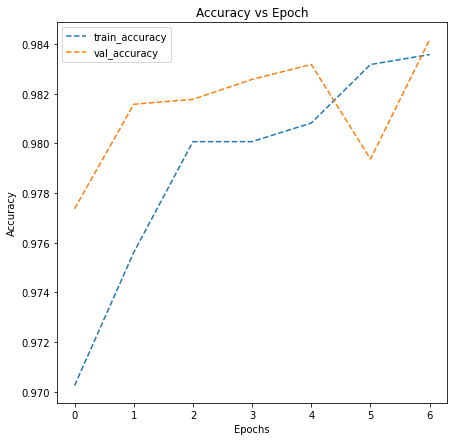

time: 198 ms (started: 2022-06-02 20:54:01 +00:00)


In [103]:
# plotting the accuracies
plot_binary_accuracy(historyX)

In [104]:
# Evaluating the model on test data
accuracyX = modelX.evaluate(test_images255, test_labels255, verbose=1)
print('\n', 'Test_Accuracy:-', accuracyX[1])

82/82 [==============================] - 16s 188ms/step - loss: 0.0443 - binary_accuracy: 0.9881

 Test_Accuracy:- 0.98807692527771
time: 16.2 s (started: 2022-06-02 20:54:01 +00:00)


              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1300
           1       0.98      0.99      0.99      1300

    accuracy                           0.99      2600
   macro avg       0.99      0.99      0.99      2600
weighted avg       0.99      0.99      0.99      2600



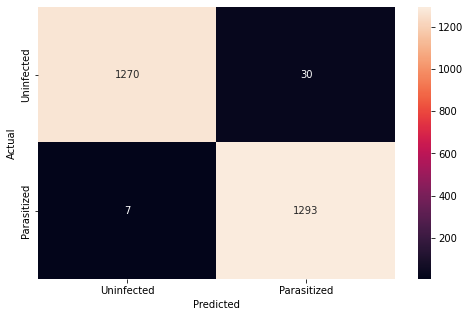

time: 15.9 s (started: 2022-06-02 20:54:17 +00:00)


In [105]:
pred = modelX.predict(test_images255)

# Note, that I needed to convert the resultant prediction values to integer labels
predcopy = copy.deepcopy(pred)
i=0
for cell in pred:
  if(cell>0):
    predcopy[i]=1
  else:
    predcopy[i]=0
  i=i+1

predcopy.astype(int)

# pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1) #test_labels #255 #

#Printing the classification report
print(classification_report(y_true,predcopy))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,predcopy)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### **Xception Observations**

* Utilizing the pre-trained Xception CNN provided **great results**.  On par with Model3.
* However, training took much longer than Model3 and the validation accuracy curve is far away from the training curve.  It was the fine tuning phase of training that took the most time.  Training the classification layer with the base model frozen was much faster.  That said, the fine tuning was worth the effort, improving validation accuracy from 0.94 to 0.99.

### Comparing Models

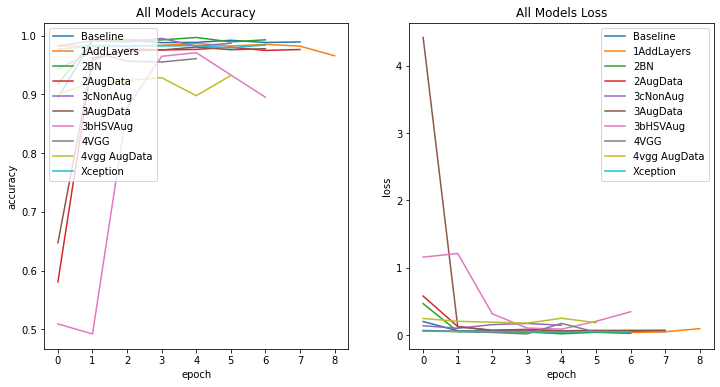

time: 369 ms (started: 2022-06-02 20:54:33 +00:00)


In [106]:
plt.figure(figsize=(12,6))
# summarize history for accuracy
plt.subplot(121)
plt.plot(history.history['val_accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.plot(history2aug.history['val_accuracy'])
plt.plot(history3c.history['val_accuracy'])
plt.plot(history3aug.history['val_accuracy'])
plt.plot(history3baughsv.history['val_accuracy'])
plt.plot(history4vgg.history['val_accuracy'])
plt.plot(history_vggaug.history['val_accuracy'])
plt.plot(historyX.history['val_binary_accuracy'])
plt.title('All Models Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Baseline', '1AddLayers', '2BN', '2AugData', '3cNonAug', '3AugData', '3bHSVAug', '4VGG', '4vgg AugData', 'Xception'], loc='upper left')
# summarize history for loss
plt.subplot(122)
plt.plot(history.history['val_loss'])
plt.plot(history1.history['val_loss'])
plt.plot(history2.history['val_loss'])
plt.plot(history3aug.history['val_loss'])
plt.plot(history4vgg.history['val_loss'])
plt.plot(history2aug.history['val_loss'])
plt.plot(history3baughsv.history['val_loss'])
plt.plot(history3c.history['val_loss'])
plt.plot(history_vggaug.history['val_loss'])
plt.plot(historyX.history['val_loss'])
plt.title('All Models Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Baseline', '1AddLayers', '2BN', '2AugData', '3cNonAug', '3AugData', '3bHSVAug', '4VGG', '4vgg AugData', 'Xception'], loc='upper right')
plt.show()

### <B>Model Descriptions with naming conventions the various techniques, for reference.</B>
•	Model.  The baseline CNN model with 3 blocks.
>* "Baseline"

•	Model1.  CNN model with 5 blocks.
>* "1AddLayers"

•	Model2.  CNN model with 3 blocks and batch normalization.

>* "2BN" and "2AugData"

•	Model3.  CNN model with 5 blocks and batch normalization.

>*"3cNonAug", "3AugData", and "3bHSVAug"

•	Model4VGG.  Transfer learning using the VGG-16 pre-trained CNN model, with imagenet weights.

>*"4VGG" and "4vgg AugData"

•	ModelX.  Transfer learning using the Xception pre-trained CNN model.

>*"Xception"


In [107]:
# serialize model 3 to JSON
model3_json = model3.to_json()

with open("model3.json", "w") as json_file:
    json_file.write(model3_json)
# serialize weights to HDF5
model3.save_weights("model3.h5")
print("Saved model 3 to disk")

# serialize model X to JSON
modelX_json = modelX.to_json()
with open("modelX.json", "w") as json_file:
    json_file.write(modelX_json)
# serialize weights to HDF5
modelX.save_weights("modelX.h5")
print("Saved model X to disk")

Saved model 3 to disk
Saved model X to disk
time: 312 ms (started: 2022-06-02 20:54:34 +00:00)


In [108]:
notebook_runtime = datetime.now() - notebook_starttime

print("\nTotal Notebook Run Time:  " + str(notebook_runtime))


Total Notebook Run Time:  2:29:50.994668
time: 1.19 ms (started: 2022-06-02 20:54:34 +00:00)


### **Refined data insights**:

•	The data provided for this project lends itself to fairly easy detection of parasitized blood cells.  Just looking at the cell images, one can see clear markers for malaria.  
•	As such, simpler may prove to be better when applying deep learning techniques to the problem.  
•	In fact, various data augmentation techniques applied to the problem did not significantly improve the results.  The baseline model started us off at 0.98 for precision, recall, accuracy, and F1 Score.  While other techniques and models reach similar performance heights, they did so at the cost of complexity and run-time.
* The parasitic markers in the data appear to be well enough defined and we seem to have enough data.  

## <b> Discussion:</b>

While some of the models performed marginally better than others, most of the models performed at or above the 0.98 level for the measures of success being tracked (Recall, precision, F1-Score, accuracy, etc..).  Pretty much any of these models would do, with the exception of the VGG transfer learned model.   I may have done something wrong, still investigating, but overall VGG transfer learning did not provide the results I was hoping for.  The good news is that the Xception model did achieve good results with transfer learning.

Data Augmentation and transformation to HSV format did not provide enough of an improvement to merit inclusion in the model flow.  Measures of success were ‘good enough’, but not worth the extra complexity.  This may be an area for further research.  Hyper parameters in the data augmentation process could improve this technique’s effects.



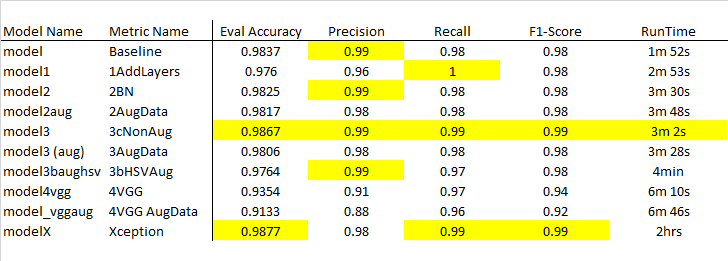

# PROPOSAL FOR THE FINAL SOLUTION DESIGN

The fastest model that performed great was Model 3, so we saved that one.  The highest performing model was arguably the Xception transfer learning model, so we saved that one as well; however, this took a long time to train so it is not preferred.  It may be worthwhile to have ready in the future should we decide to expand this work.

## Highest Performing Models
•	Model1 had the highest Recall.

•	Model3 had the highest measures of success overall.

•	Xception had higher accuracy than Model3, and the same Recall.

## Great Performance, Less Run-Time, and Lesser Complexity
•	Model3.  Not only did Model3 perform as well or better than the other models, but it is also not that complex or computationally expensive, and it trains relatively quickly.

# <b>Model proposed for adoption</b>
•	Model3.  For the reasons described above, fast and accurate.  I recommend using Model3 without any data transformations or data augmentation.  


## <b> Conclusion, with recommendations for future work improvements: </b>

•	More work is needed to further validate the models and run experiments using additional techniques.  In particular, other researchers have used the Autoencoder framework to great success, replacing the decoder with a classifier.  This study in particular demonstrated very low computational expense.  Others have applied different data augmentation techniques, feature extraction, classification by a Support Vector Machine (SVM) or K-Nearest Neighbors (KNN), and various training procedures to optimize and improve the model accuracy and inference performance.  

•	The chosen model, **Model3**, is running great, without data augmentation, but revisions to this model could yield additional improvements, such as changing the activation functions, number of filters/channels, and different normalization and dropout rates.  We could also fit the model with different learning rates and other hyperparameters.  Lastly, we should experiment with simpler versions of model3 to reduce computational expense.

•	In this study, we used VGG and Xception pre-trained networks, but others could be explored as well.  That said, current models already perform well enough.  We may want to run the Xception network without augmented data, which seemed to lessen our success in other models.

•	A final recommendation is to review the images that were predicted incorrectly.  Other studies using this data indicated that some of the training data is mis-labeled.  Removing the incorrectly labeled cell images would give us a more accurate assessment of model performance.

•	We recommend to continue this work, which shows great promise for detecting malaria.  Model3 should work great in practice!  With some additional techniques, we may be able to make it work even better.


